### This is based on the kaggle article : https://www.kaggle.com/ktattan/lda-and-document-similarity

In [59]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
from scipy.special import rel_entr, kl_div
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# Load the processed file 
file_path = '../processed-data/processed_file.csv'
df = pd.read_csv( file_path)

In [3]:
df.head()

,Unnamed: 0,cord_uid,title,abstract,pdf_abstract_text,pdf_body_text,pmc_abstract_text,pmc_body_text
0,0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,Objective: This retrospective chart review des...,Mycoplasma pneumoniae is a common cause of upp...,NaN,Mycoplasma pneumoniae is a common cause of upp...
1,1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,Inflammatory diseases of the respiratory tract...,Since its discovery as a biological messenger ...,NaN,Since its discovery as a biological messenger ...
2,2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,Surfactant protein-D (SP-D) participates in th...,Surfactant protein-D (SP-D) is a member of the...,NaN,Surfactant protein-D (SP-D) is a member of the...
3,3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,ARDS = acute respiratory distress syndrome; BA...,from Xenopus laevis [16] . ETA receptors in no...,NaN,"ET-1, ET-2, and ET-3 are members of a peptide ..."
4,4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,commentary review reports primary research CCR...,RSV and PVM are viruses of the family Paramyxo...,NaN,RSV and PVM are viruses of the family Paramyxo...


In [4]:
# Merge some columns


# drop rows for which title columns are null
df.dropna(inplace=True, subset=['title'])
# drop a row if all the abstract and body columns are nan
df.dropna(inplace=True, subset=['abstract','pdf_abstract_text', 'pmc_abstract_text'  ], how='all')

# We still need to fill all NAN with '', because one of the abstract texts or body  might be NAN and adding makes it NAN
df.fillna('', inplace=True) 

df['abstract'] = df['abstract'] + df['pdf_abstract_text'] + df['pmc_abstract_text']
df['body'] = df['pdf_body_text'] + df['pmc_body_text']


df['text'] = df['abstract'] + df['body']

In [5]:
# subset of columns and shuffle the data
df_new = df[['cord_uid','title', 'text']]
df_new = df_new.sample(frac=1.0)
df_new.reset_index(drop=True,inplace=True)



In [6]:
df_new = df_new.head(10000)

In [9]:
print(len(df_new))

10000


In [8]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [10]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [11]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df_new['tokenized'] = df_new['title'].apply(apply_all) + df_new['text'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df_new), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 10000 articles: 21.47019906838735 min


In [12]:
# first get a list of all words
all_words = [word for item in list(df_new['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

344153

In [13]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('radiotelemetri', 11),
 ('reit', 11),
 ('batten', 11),
 ('jewelri', 11),
 ('ktx', 11),
 ('antigbm', 11),
 ('requirementgath', 11),
 ('postconcept', 11),
 ('catherin', 11),
 ('ahrf', 11)]

In [14]:
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('seminest', 73),
 ('cellen', 73),
 ('lpv', 73),
 ('ppl', 73),
 ('silvestrol', 73),
 ('beginarrayl', 73),
 ('weanl', 73),
 ('basv', 73),
 ('pathotyp', 73),
 ('psmb', 73)]

In [15]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [16]:
df_new['tokenized'] = df_new['tokenized'].apply(keep_top_k_words)

In [17]:
# document length
df_new['doc_len'] = df_new['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df_new['doc_len'])
df_new.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 10000 
average document length 2175.0373 
minimum document length 2 
maximum document length 122101


C:\Software\miniconda3\envs\nlp-conda-py37\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


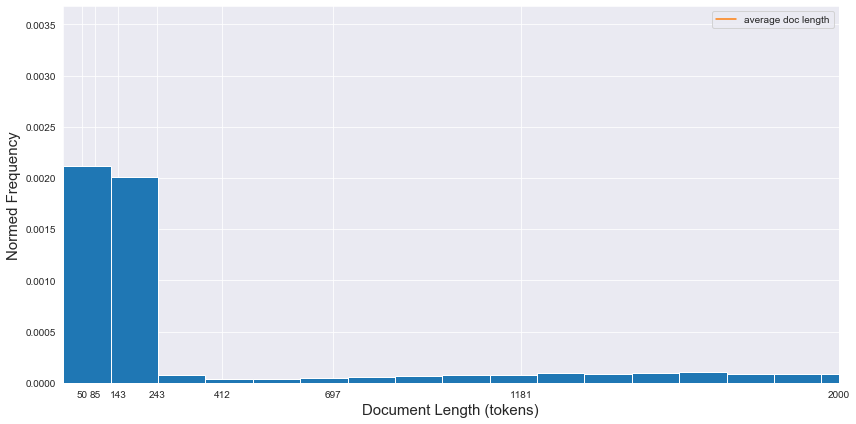

In [18]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

## Drop short articles

In [20]:
#only keep articles with more than 30 tokens, otherwise too short
df_new = df_new[df_new['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df_new = df_new[df_new['tokenized'].map(type) == list]
df_new.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df_new), "articles")

After cleaning and excluding short aticles, the dataframe now has: 9757 articles


### Split the corpus into training and testing

In [21]:
msk = np.random.rand(len(df_new)) < 0.999

train_df = df_new[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df_new[~msk]
test_df.reset_index(drop=True,inplace=True)

In [22]:
print(len(df_new),len(train_df),len(test_df))

9757 9750 7


## LDA

In [23]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df_new), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [24]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  9757 articles:  1.9707385778427124 min


In [25]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(26,
  '0.100*"bat" + 0.057*"human" + 0.043*"transmiss" + 0.023*"cov" + 0.020*"viru" + 0.017*"speci" + 0.017*"virus" + 0.017*"hcw" + 0.016*"reservoir" + 0.016*"rabi" + 0.015*"infect" + 0.013*"detect" + 0.013*"hcov" + 0.011*"zoonot" + 0.011*"outbreak" + 0.011*"studi" + 0.011*"ebola" + 0.010*"host" + 0.010*"contact" + 0.009*"identifi"'),
 (41,
  '0.022*"air" + 0.018*"temperatur" + 0.016*"use" + 0.015*"mask" + 0.012*"particl" + 0.012*"aerosol" + 0.010*"room" + 0.010*"droplet" + 0.008*"water" + 0.008*"protect" + 0.008*"concentr" + 0.008*"bioaerosol" + 0.008*"wast" + 0.007*"transmiss" + 0.007*"clean" + 0.007*"environ" + 0.007*"contamin" + 0.007*"equip" + 0.007*"hand" + 0.007*"measur"'),
 (16,
  '0.070*"women" + 0.061*"pregnanc" + 0.040*"neonat" + 0.038*"birth" + 0.038*"pregnant" + 0.036*"matern" + 0.030*"fetal" + 0.023*"deliveri" + 0.022*"mother" + 0.021*"preterm" + 0.020*"infant" + 0.020*"gestat" + 0.016*"week" + 0.015*"placenta" + 0.014*"placent" + 0.013*"babi" + 0.012*"newborn" + 0.011*

In [26]:
lda.show_topic(topicid=4, topn=20)

[('residu', 0.047229905),
 ('site', 0.040244494),
 ('acid', 0.037930567),
 ('amino', 0.0288174),
 ('activ', 0.024526961),
 ('cleavag', 0.022744553),
 ('fig', 0.020688724),
 ('substrat', 0.019287009),
 ('domain', 0.014636346),
 ('enzym', 0.014122783),
 ('posit', 0.013465604),
 ('ace', 0.011763569),
 ('pro', 0.011732952),
 ('ii', 0.010834131),
 ('ang', 0.009734285),
 ('bind', 0.007928009),
 ('protein', 0.007814674),
 ('ntermin', 0.0076972498),
 ('peptid', 0.0076149246),
 ('receptor', 0.0074201575)]

In [29]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,3])
print(random_article_index)

9236


In [30]:
print(train_df.iloc[random_article_index,3])

['evalu', 'minim', 'invas', 'surgeri', 'new', 'platform', 'surgeri', 'purpos', 'studi', 'aim', 'evalu', 'feasibl', 'safeti', 'new', 'minim', 'invas', 'surgeri', 'platform', 'treat', 'rectal', 'lesion', 'method', 'first', 'compar', 'two', 'minim', 'invas', 'surgeri', 'platform', 'sil', 'port', 'path', 'human', 'cadav', 'surgeon', 'differ', 'experi', 'perform', 'run', 'sutur', 'differ', 'distanc', 'four', 'quadrant', 'use', 'three', 'platform', 'gave', 'score', 'visibl', 'safeti', 'util', 'patient', 'affect', 'rectal', 'neoplasia', 'met', 'inclus', 'criteria', 'patient', 'tumor', 'characterist', 'result', 'prospect', 'collect', 'followup', 'examin', 'includ', 'month', 'result', 'accord', 'surgeon', 'score', 'improv', 'visibl', 'safeti', 'respect', 'platform', 'distanc', 'beyond', 'cm', 'procedur', 'last', 'averag', 'min', 'success', 'carri', 'patient', 'intraop', 'postop', 'complic', 'report', 'mean', 'tumor', 'size', 'cm', 'locat', 'mean', 'cm', 'anal', 'complet', 'remov', 'lesion', 'po

In [31]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

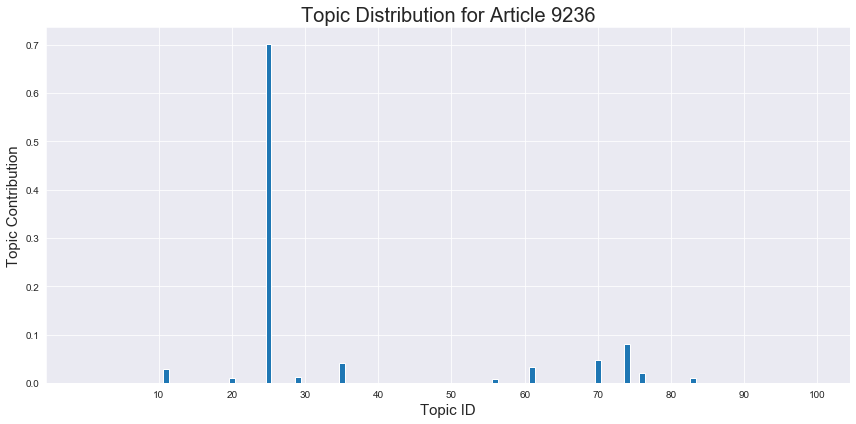

In [32]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [33]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

25 [('patient', 0.0337909), ('surgeri', 0.019093245), ('use', 0.015294768), ('surgic', 0.013764391), ('perform', 0.0129418615), ('procedur', 0.012248977), ('result', 0.010099537), ('complic', 0.009949503), ('conclus', 0.009454769), ('postop', 0.008467226)] 

74 [('data', 0.061395824), ('inform', 0.026121829), ('system', 0.024620092), ('use', 0.023559304), ('surveil', 0.014581), ('provid', 0.014226834), ('diseas', 0.013410454), ('user', 0.009619772), ('identifi', 0.008976487), ('includ', 0.0080997)] 

70 [('studi', 0.06270456), ('review', 0.030583719), ('use', 0.017010998), ('includ', 0.015172953), ('literatur', 0.013266579), ('effect', 0.0120062195), ('evid', 0.011698395), ('systemat', 0.011385298), ('search', 0.010870987), ('assess', 0.009832612)] 

35 [('compound', 0.038085885), ('activ', 0.03596368), ('hz', 0.03011276), ('ch', 0.01792978), ('nmr', 0.0154499775), ('ic', 0.01327254), ('deriv', 0.01260004), ('acid', 0.011741188), ('yield', 0.010378935), ('valu', 0.010046996)] 

61 [('t

## Similarity Queries and unseen data

In [34]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

4


In [35]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,3])

In [36]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

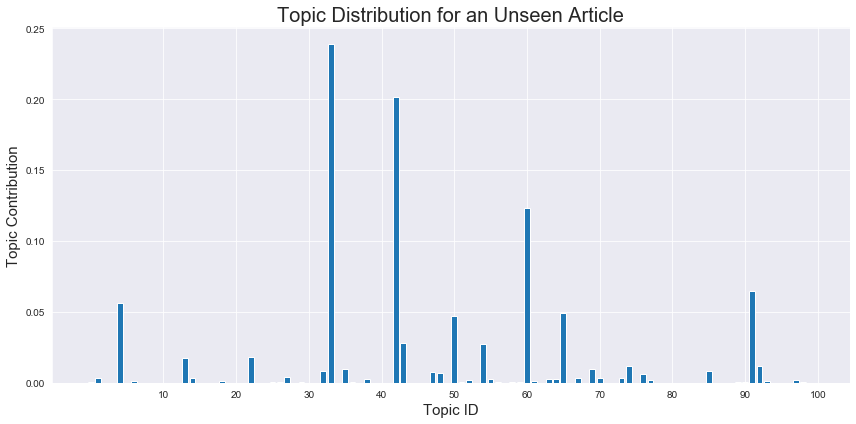

In [37]:
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [38]:
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

33 [('protein', 0.064757295), ('membran', 0.026693834), ('cell', 0.017529856), ('interact', 0.010420918), ('domain', 0.01003018), ('fusion', 0.009449606), ('golgi', 0.009179562), ('cytoplasm', 0.008108852), ('cellular', 0.007558614), ('function', 0.0071514747)] 

42 [('structur', 0.051937103), ('interact', 0.03125534), ('bind', 0.021132581), ('complex', 0.013878811), ('residu', 0.01210304), ('molecul', 0.0117277065), ('domain', 0.011453247), ('bond', 0.010938869), ('form', 0.010658628), ('conform', 0.010313899)] 

60 [('et', 0.32194638), ('al', 0.3218096), ('studi', 0.00885456), ('also', 0.005837216), ('found', 0.004433739), ('report', 0.004019752), ('may', 0.0036188585), ('differ', 0.0036105607), ('van', 0.0035214247), ('howev', 0.0034301444)] 

91 [('transport', 0.046235938), ('emiss', 0.030695751), ('energi', 0.029204551), ('co', 0.02223551), ('increas', 0.017103782), ('forc', 0.01638389), ('tio', 0.01411625), ('channel', 0.013827453), ('portabl', 0.013307202), ('ir', 0.012957813)] 

### Similarity query

In [39]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(9750, 100)

In [60]:
def entropy_custom(pk, qk=None, base=None):
    """Calculate the entropy of a distribution for given probability values.

    If only probabilities `pk` are given, the entropy is calculated as
    ``S = -sum(pk * log(pk), axis=0)``.

    If `qk` is not None, then compute the Kullback-Leibler divergence
    ``S = sum(pk * log(pk / qk), axis=0)``.

    This routine will normalize `pk` and `qk` if they don't sum to 1.

    Parameters
    ----------
    pk : sequence
        Defines the (discrete) distribution. ``pk[i]`` is the (possibly
        unnormalized) probability of event ``i``.
    qk : sequence, optional
        Sequence against which the relative entropy is computed. Should be in
        the same format as `pk`.
    base : float, optional
        The logarithmic base to use, defaults to ``e`` (natural logarithm).

    Returns
    -------
    S : float
        The calculated entropy.

    """
    pk = np.asarray(pk)
    pk = 1.0*pk / np.sum(pk, axis=0)
    if qk is None:
        vec = entr(pk)
    else:
        qk = np.asarray(qk)
       
        qk = 1.0*qk / np.sum(qk, axis=0)
        #vec = rel_entr(pk, qk)
        vec = kl_div(pk, qk)
    S = np.sum(vec, axis=0)
    if base is not None:
        S /= log(base)
    return S


def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy_custom(p,m) + entropy_custom(q,m)))

In [61]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [62]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [63]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df['title']

848     Overview of Protein Structural and Functional ...
1174    Atomistic Autophagy: The Structures of Cellula...
1484    The RNA-binding site of poliovirus 3C protein ...
2172    CORONAVIRUS E PROTEIN FORMS ION CHANNELS WITH ...
3358    Lipids as modulators of membrane fusion mediat...
3576             The three lives of viral fusion peptides
4569    The Location of the Protonated and Unprotonate...
7540    Nucleotide sugar transporters of the Golgi app...
8322    Viral ion channel proteins in model membranes:...
9441    Sialylation of N-glycans: mechanism, cellular ...
Name: title, dtype: object